# Twitter Sentiment Analysis

### 1. Installing and Importing Libraries

In [11]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

### 2. Authentication for Twitter API

In [12]:
consumerKey = 'uYOQyrDxu3N4DhvnVg4MHKuGy'
consumerSecret = "7d3utI5xlEzxzBlvMEIyAEtXs82NHrVSbDvHOPUGrYS0FAIEKY"
accessToken = '1146475292057227264-5qeqpVgxqXlqaDDOWQ8AYzPysLlYsb'
accessTokenSecret = 'Z7FNP3cPmppHgHjm4kgFgD2ypcUsaGmmin47BmbfM7z1O'
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

### 3. Getting Tweets with Keyword or Hashtag

In [60]:
def percentage(part,whole):
     return 100 * float(part)/float(whole)
keyword = input('Please enter keyword or hashtag to search: ')
noOfTweet = int(input ('Please enter how many tweets to analyze: '))
tweets = tweepy.Cursor(api.search_tweets, q=keyword).items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets: 
    
 #print(tweet.text)
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1

    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Please enter keyword or hashtag to search: Crimea
Please enter how many tweets to analyze: 1000


In [61]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

total number:  1000
positive number:  156
negative number:  434
neutral number:  410


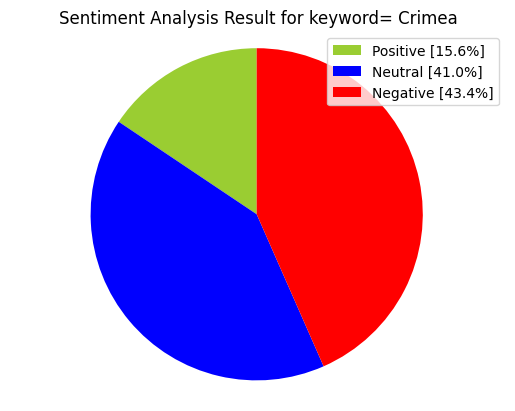

In [62]:
#Creating PieCart
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis Result for keyword= '+keyword+'' )
plt.axis('equal')
plt.show()

In [74]:
tweet_list

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @Crimea: Good morning from Crimea! 😎\n#With...,RT @Crimea: Good morning from Crimea! 😎\n#With...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
1,RT @DarthPutinKGB: Section of Crimea Bridge wa...,RT @DarthPutinKGB: Section of Crimea Bridge wa...,0.0,0.0,neutral,0.0,0.0,0.0,0.0
2,RT @visegrad24: BREAKING:\nThe Kerch Strait Br...,RT @visegrad24: BREAKING:\nThe Kerch Strait Br...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,RT @EwanMacKenna: Those that know far more tha...,RT @EwanMacKenna: Those that know far more tha...,0.0,0.0,neutral,0.0,0.0,0.0,0.0
4,RT @tomiahonen: LOL Finnish Prime Minister San...,RT @tomiahonen: LOL Finnish Prime Minister San...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
986,@An_Najimy001 @decemberdust1 @LvivTyler 🤣🤣 is ...,@An_Najimy001 @decemberdust1 @LvivTyler 🤣🤣 is ...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
988,Massive explosion cripples Crimea's Kerch brid...,Massive explosion cripples Crimea's Kerch brid...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
992,RT @martaottaviani: Altro regalo per il comple...,RT @martaottaviani: Altro regalo per il comple...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
993,@CovertShores @Tendar @COUPSURE @CorporalFrisk...,@CovertShores @Tendar @COUPSURE @CorporalFrisk...,0.0,0.0,neutral,0.0,1.0,0.0,0.0


### 4. Cleaning Tweets to Analyse Sentiment

In [78]:
#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list['text'] = tw_list[0]
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: ',' ',x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list['text'] = tw_list.text.map(remove_rt).map(rt)
tw_list['text'] = tw_list.text.str.lower()
tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @Crimea: Good morning from Crimea! 😎\n#With...,good morning from crimea withoutbridge c...,0.00,0.0,neutral,0.0,1.0,0.0,0.0
1,RT @DarthPutinKGB: Section of Crimea Bridge wa...,section of crimea bridge was promoted to tunnel,0.00,0.0,neutral,0.0,0.0,0.0,0.0
2,RT @visegrad24: BREAKING:\nThe Kerch Strait Br...,breaking the kerch strait bridge connecting...,0.00,0.0,neutral,0.0,1.0,0.0,0.0
3,RT @EwanMacKenna: Those that know far more tha...,those that know far more than i think that cr...,0.00,0.0,neutral,0.0,0.0,0.0,0.0
4,RT @tomiahonen: LOL Finnish Prime Minister San...,lol finnish prime minister sanna marin was ju...,0.00,0.0,neutral,0.0,1.0,0.0,0.0
5,RT @GeromanAT: #Russia #Crimea \nRybar's point...,russia crimea rybar s point of view russ...,-0.75,1.0,neutral,0.0,0.0,0.0,0.0
6,RT @DefenceU: The guided missile cruiser Moskv...,the guided missile cruiser moskva and the ker...,0.00,0.0,neutral,0.0,0.0,0.0,0.0
7,RT @trbrtc: “Putin should be happy. Not everyo...,putin should be happy not everyone gets suc...,0.00,0.0,neutral,0.0,1.0,0.0,0.0
8,RT @puresoulfree: Momento della massiccia espl...,momento della massiccia esplosione sul ponte ...,0.00,0.0,neutral,0.0,0.0,0.0,0.0
9,"RT @KyivIndependent: He said that ""everything ...",he said that everything stolen must be retur...,0.00,0.0,neutral,0.0,1.0,0.0,0.0


### 5. Sentiment Analyse

In [79]:
tw_list[['polarity','subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = 'negative'
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = 'positive'
    else:
        tw_list.loc[index, 'sentiment'] = 'neutral'
        tw_list.loc[index, 'neg'] = neg
        tw_list.loc[index, 'neu'] = neu
        tw_list.loc[index, 'pos'] = pos
        tw_list.loc[index, 'compound'] = comp

tw_list.head(10)



,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @Crimea: Good morning from Crimea! 😎\n#With...,good morning from crimea withoutbridge c...,0.700000,0.600000,positive,0.0,1.0,0.0,0.0
1,RT @DarthPutinKGB: Section of Crimea Bridge wa...,section of crimea bridge was promoted to tunnel,0.000000,0.000000,positive,0.0,0.0,0.0,0.0
2,RT @visegrad24: BREAKING:\nThe Kerch Strait Br...,breaking the kerch strait bridge connecting...,0.000000,0.000000,negative,0.0,1.0,0.0,0.0
3,RT @EwanMacKenna: Those that know far more tha...,those that know far more than i think that cr...,0.200000,0.533333,negative,0.0,0.0,0.0,0.0
4,RT @tomiahonen: LOL Finnish Prime Minister San...,lol finnish prime minister sanna marin was ju...,0.800000,0.700000,positive,0.0,1.0,0.0,0.0
5,RT @GeromanAT: #Russia #Crimea \nRybar's point...,russia crimea rybar s point of view russ...,-0.097222,0.180556,negative,0.0,0.0,0.0,0.0
6,RT @DefenceU: The guided missile cruiser Moskv...,the guided missile cruiser moskva and the ker...,0.000000,0.000000,negative,0.0,0.0,0.0,0.0
7,RT @trbrtc: “Putin should be happy. Not everyo...,putin should be happy not everyone gets suc...,0.040000,0.460000,positive,0.0,1.0,0.0,0.0
8,RT @puresoulfree: Momento della massiccia espl...,momento della massiccia esplosione sul ponte ...,0.000000,0.000000,neutral,0.0,1.0,0.0,0.0
9,"RT @KyivIndependent: He said that ""everything ...",he said that everything stolen must be retur...,0.000000,0.000000,negative,0.0,1.0,0.0,0.0


### Creating new data frames for all sentiments (positive, negative and neutral)

In [80]:

tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [92]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])#Count_values for sentiment
df = count_values_in_column(tw_list,'sentiment')

In [93]:
df

,Total,Percentage
neutral,256,48.30
negative,171,32.26
positive,103,19.43


### create data for Pie Chart

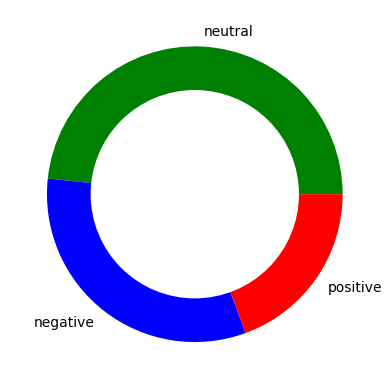

In [94]:

pichart = count_values_in_column(tw_list,'sentiment')
names= df.index
size=df['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()